(sec:GenFxnCoeffCalc)=
# Numerical Calculation of PGF coefficients

There are times when we may want to find coefficients of a generating function, but we do not have an analytic function.  One scenario where this might occur would be where we know $\mu(x)$ but we want to find the coefficients of $\Phi_g(x) = \mu^{(g)}(x)$.

## Symbolic calculation
The natural first attempt is to simply take the series expansion of $\mu(x)$, plug it into itself repeatedly while tracking the coefficients.  Using one of the simplest possible examples, if $\mu(x) = (1+x^2)/2$, then 

\begin{align*}
\Phi_1(x) &= \mu(x) = \frac{1+x^2}{2}\\
\Phi_2(x) &= \mu(\Phi_1(x)) = \frac{1+ \frac{1 + 2x^2 + x^4}{4}}{2} = \frac{5 + 2x^2 + x^4}{8}\\
\Phi_3(x) &= \mu(\Phi_2(x)) = \frac{1 + \frac{25 + 20x^2 + 14x^4 +4x^6 + x^8}{64}}{2} = \frac{89 + 20x^2 + 14x^4 + 4x^6 + x^8}{128}\\
& \vdots
\end{align*}
Although this approach will work if the $\mu(x)$ is simple enough, the number of calculations at each level grows quickly.  The code below uses Python's `sympy` package for symbolic calculation.  To check the run time, it uses Python's `timeit` package and runs many simulations, and plots the median run time for different $\Phi_g$.  

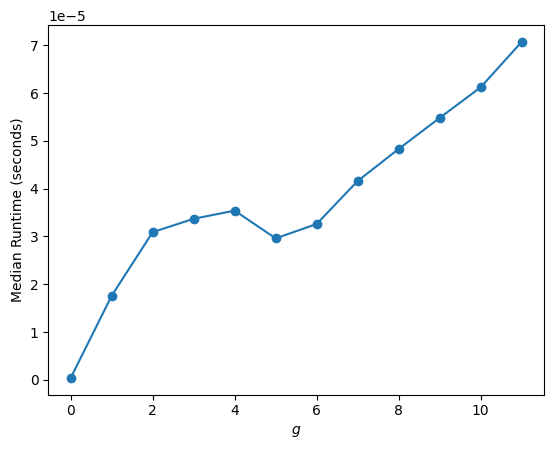

In [58]:
import sympy as sp  #package that allows symbolic computation
import timeit
import matplotlib.pyplot as plt
import statistics

x = sp.Symbol("x")


def Phi(g, mu):
    """
    Return Phi_g(x) defined by:
      Phi_0(x) = x
      Phi_{g+1}(x) = mu(Phi_g(x))
    as a fully expanded SymPy expression.
    """
    if g < 0 or not isinstance(g, int):
        raise ValueError("g must be a nonnegative integer")
    intermediate_Phi = x
    for _ in range(g):
        intermediate_Phi = sp.expand(mu(intermediate_Phi))
    return intermediate_Phi


def time_Phi(g, mu, repeats=3):
    """
    Median runtime of Phi(g) over `repeats` runs.
    """
    stmt = lambda: Phi(g, mu)
    t = timeit.repeat(stmt, number=1, repeat=repeats)
    return statistics.median(t)


# example mu
def mu(expr):
    """Offspring PGF: mu(x) = (1 + x^2)/2."""
    return sp.Rational(1, 2) * (1 + expr**2)

# choose g values - 
g_values = range(12)
times = [time_Phi(g, mu, repeats=201) for g in g_values]

# plot
plt.figure()
plt.plot(g_values, times, marker="o")
plt.xlabel("$g$")
plt.ylabel("Median Runtime (seconds)")
plt.show()



In the code above, if I run with a larger $g$, it suddenly slows down (I've never waited long enough to see if it will stop).  I presume it is running out of memory to hold all the calculations or some similar problem.  

## Vectorized calculation

A different method just uses a vector of coefficients to do the calculations.  It uses the location in the array as a proxy for $x^k$, and then it is able to do calculations without the symbolic overhead.

It is implemented below using a `numpy` array in Python.  This can run for larger $g$.  Note that we've switched to a log scale.

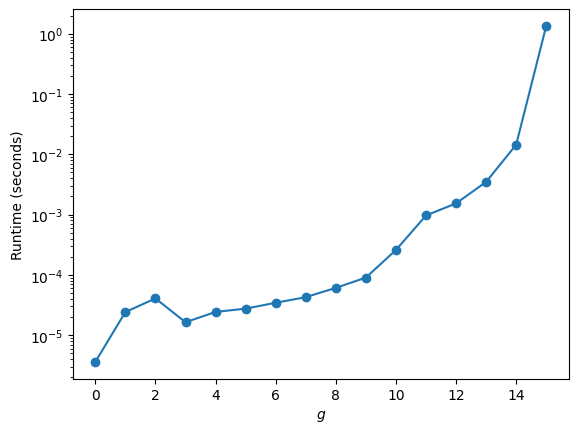

In [ ]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
import statistics


def Phi_numpy(g, mu):
    """
    Compute coefficients of Phi_g(x) using NumPy.
    Phi_0(x) = x
    Phi_{g+1}(x) = mu(Phi_g(x))

    Returns a NumPy array [a_0, ..., a_deg].
    """
    if g < 0 or not isinstance(g, int):
        raise ValueError("g must be a nonnegative integer")

    # Phi_0(x) = x
    a = np.array([0.0, 1.0])

    for _ in range(g):
        a = mu(a)

    return a


def time_Phi_numpy(g, mu, repeats=3):
    """
    Median runtime of Phi_numpy(g) over `repeats` runs.
    """
    stmt = lambda: Phi_numpy(g, mu)
    t = timeit.repeat(stmt, number=1, repeat=repeats)
    return statistics.median(t)


# example mu acting on coefficient arrays
def mu_numpy(a):
    """
    mu(x) = (1 + x^2) / 2, acting on coefficient array a.
    """
    b = np.convolve(a, a)
    b[0] += 1.0
    return 0.5 * b




# choose g values
g_values = range(16)   # you can go higher than with SymPy
times = [time_Phi_numpy(g, mu_numpy, repeats=int(101/(g+1))) for g in g_values]

# plot
plt.figure()
plt.plot(g_values, times, marker="o")
plt.xlabel(r"$g$")
plt.ylabel("Median runtime (seconds)")
plt.yscale('log')
plt.show()


## Cauchy Integration
Now we'll try a very different method.  

If you've taken Complex Analysis, you may recognize the "Cauchy integral" that can extract the coefficient of $x^k$ from $\Phi_g(x)$:

$$
[x^k]\Phi_g(x)
= \frac{1}{2\pi i}\oint_{|z|=1} \frac{\Phi_g(z)}{z^{k+1}}\,dz
$$
(here I've used the notation $[x^k]\Phi_g(x)$ to denote the coefficient of $x^k$ in $\Phi_g(x)$)
If you haven't taken Complex Analysis, don't worry, we'll rewrite the integral and then derive its properties without requiring the Complex Analysis theorems.

You may recall from Complex Analysis that it's important that $\Phi_g(z)$ doesn't have any singularities inside the unit circle $|z|=1$.  It turns out that this is guaranteed by the fact that $\Phi_g(1) = \sum_k p_k = 1$.  Since $|p_k z^k| \leq p_k$ for any $|z|\leq 1$, $\Phi_g(z)$ converges absolutely everywhere inside and on the unit circle. 

We can convert this integral into something that is easier to consider using the substitution $z = e^{i\theta}$.  Then $dz/d\theta = i e^{i\theta}$ and $dz = i e^{i\theta} d\theta$ where $\theta$ goes from $0$ to $2\pi$.  Substituting this and replacing $1/z^{k+1}$ with $e^{-i(k+1)\theta}$ yields:  

$$
\frac{1}{2\pi i}\oint_{|z|=1} \frac{\Phi_g(z)}{z^{k+1}}\,dz= \frac{1}{2\pi}\int_{0}^{2\pi} \Phi_g(e^{i\theta})\,e^{-ik\theta}\,d\theta
$$
This last integral is the integral we are going to do.

A few asides - The function $\Phi_g(e^{i\theta})$ is sometimes called the "Characterstic Function" of the distribution corresponding to $\Phi_g$.  It is also the Fourier Transform of the discrete sequence $p_{g,0}$, $p_{g,1}$, $\ldots$.  This last point is useful because there are well-established rapid methods to compute and invert the Fourier Transform of a distribution (the Fast Fourier Transform, (FFT)).  We will be able to use the FFT to calculate this integral faster than we can do it by hand.

Now let's look at this integral from the perspective of someone who hasn't taken Complex Analysis and learned about residues.

### Alternate view of Cauchy integral.
We'd like to understand why this integral finds $p_{g,k}$ without relying on Complex Analysis.

The fact that $\Phi_g(x)$ is a PGF guarantees that $|\Phi_g(z)|$ converges and its magnitude is at most $\Phi_g(1)=1$ everywhere on the unit circle.  This means we can do the following steps with the integral.  

\begin{align*}
\frac{1}{2\pi}\int_{0}^{2\pi} \Phi_g(e^{i\theta})e^{-ik\theta}\,d\theta &= \frac{1}{2\pi} \int_0^{2\pi} \sum_{j=0}^\infty p_{g,j} (e^{i\theta})^j e^{-ik\theta} \, d\theta\\
&= \frac{1}{2\pi} \sum_{j=0}^\infty p_{g,j} \int_0^{2\pi}  (e^{i\theta})^j e^{-ik\theta} \, d\theta\\
&=\frac{1}{2\pi} \sum_{j=0}^\infty p_{g,j} \int_0^{2\pi} (e^{i(j-k)\theta}) \, d\theta\\
&=\frac{1}{2\pi} \sum_{j=0}^\infty p_{g,j} \begin{cases}\int_0^{2\pi} (e^{i(j-k)\theta}) \, d\theta & j\neq k\\
\int_0^{2\pi}1\, d\theta & j=k
\end{cases}\\
&=\frac{1}{2\pi} \sum_{j=0}^\infty p_{g,j} \begin{cases} \left[\frac{1}{i(j-k)}e^{i(j-k)\theta} \right|_{\theta=0}^{2\pi} & j\neq k\\
\theta|_{\theta=0}^{2\pi} & j=k
\end{cases}\\
&=\frac{1}{2\pi} \sum_{j=0}^\infty p_{g,j} \begin{cases} 0 & j\neq k\\
2\pi & j=k
\end{cases}\\
&= p_{g,k}
\end{align*}
So seemingly miraculously, multiplying by $e^{-ik\theta}$ and integrating allows us to pick out the $k$-th coefficient.  If you've used Fourier Series before, this is the method for calculating the coefficients (for the complex case).

The code in the cell below calculates $\Phi_g(z)$ at a bunch of points on the unit circle, by starting with $\Phi_0(z)$ at $e^{2i\pi m/N}$ for a large value of $M$.  Then it iteratively finds $\Phi_{g+1}(z) = \mu(\Phi_g(z))$ at those points.  Once it's calculated up to the desired $g$, it can use a Riemann sum to calculate the integral above to find a desired coefficient.  However, since the FFT is designed to work with values like these, it can also use the more efficient FFT methods to calculate all of the coefficients at once.  By default it uses the FFT speed-up.




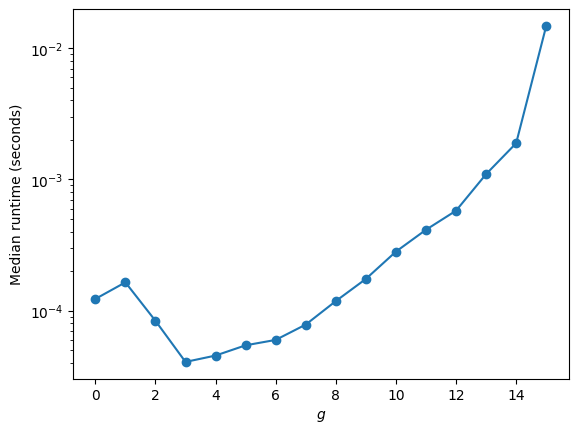

In [64]:
import numpy as np
import timeit
import statistics


def Phi_values_on_unit_circle(g, num_points, mu):
    """
    Compute values of Phi_g(z) at equally spaced points on the unit circle:
        z_m = exp(2*pi*i*m/num_points),  m = 0,...,num_points-1

    Here mu is a function that acts on an array of complex values (pointwise),
    returning mu(values).
    """
    if g < 0 or not isinstance(g, int):
        raise ValueError("g must be a nonnegative integer")

    m = np.arange(num_points)
    z_points = np.exp(2j * np.pi * m / num_points)

    values = z_points.copy()   # Phi_0(z) = z
    for _ in range(g):
        values = mu(values)

    return values, z_points


def Phi_coefficients_via_cauchy(g, num_points, mu, FFT=True):
    """
    Compute coefficients of Phi_g(x) either using the discrete Cauchy integral
    (trapezoidal rule on the unit circle), or the FFT.

    Returns coefficients a_0, ..., a_{num_points-1}.
    """
    values, z_points = Phi_values_on_unit_circle(g, num_points, mu)

    if FFT:  # Fast Fourier Transform is equivalent to calculation below, but much faster
        #coefficients = np.fft.ifft(values)
        coefficients = np.fft.fft(values) / num_points
    else:
        coefficients = np.zeros(num_points, dtype=complex)
        for k in range(num_points):
            # a_k = (1/num_points) * sum_m Phi_g(z_m) * z_m^{-k}
            coefficients[k] = np.sum(values * z_points**(-k)) / num_points

    return coefficients


def Phi_coefficients_real(g, num_points, mu, tolerance=1e-12, FFT=True):
    """
    Return real coefficients when imaginary parts are numerical noise.
    """
    coeffs = Phi_coefficients_via_cauchy(g, num_points, mu, FFT=FFT)
    if np.max(np.abs(coeffs.imag)) < tolerance:
        return coeffs.real
    return coeffs


def time_Phi_Cauchy(g, mu, repeats=3, FFT=True):
    """
    Median runtime of Phi_coefficients_real(g, num_points, mu) over `repeats` runs.
    """
    degree = 2 ** g
    num_points = 2 * degree   # must be > degree

    stmt = lambda: Phi_coefficients_real(g, num_points, mu, FFT=FFT)
    t = timeit.repeat(stmt, number=1, repeat=repeats)
    return statistics.median(t)


# example mu acting pointwise on complex values: mu(x) = (1 + x^2)/2
def mu_Cauchy(values):
    return 0.5 * (1.0 + values * values)


# choose g values
g_values = range(16)   # you can go higher than with SymPy
times = [time_Phi_Cauchy(g, mu_Cauchy, repeats=int(101/(g+1))) for g in g_values]

# plot
plt.figure()
plt.plot(g_values, times, marker="o")
plt.yscale('log')
plt.xlabel(r"$g$")
plt.ylabel("Median runtime (seconds)")
plt.show()



Now let's compare these methods.  We'll use a different $\mu(x)$:  $\mu(x) = (1+x+2x^2)/4$.  We'll first look at run-time.  The Cauchy method wins out as $g$ gets larger.  We have to stop the symbolic computation at an early $g$ because it seems to get stuck.

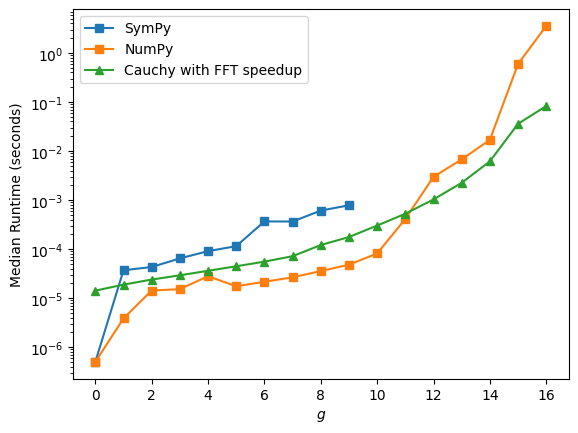

In [65]:
# --- new mu for mu(x) = (1 + x + 2x^2)/4 ---

import sympy as sp
import numpy as np

x = sp.Symbol("x")

def mu_sympy(expr):
    # SymPy expression -> SymPy expression
    return (1 + expr + 2*expr**2) / sp.Integer(4)

def mu_numpy_coeffs(a):
    # coefficient array a -> coefficient array for (1 + p + 2p^2)/4
    b = np.convolve(a, a)              # p^2
    out = np.zeros(len(b), dtype=float)
    out[0] += 1.0                      # +1
    out[:len(a)] += a                  # +p
    out += 2*b                         # +2p^2
    return out / 4.0

def mu_Cauchy_values(values):
    # pointwise on complex values on unit circle
    return (1.0 + values + 2*values**2) / 4.0


# --- run the existing timing tests (assuming your time_* functions already exist) ---

sympy_g_values = range(10)  #sympy seems to run forever once g=10.
sympy_times = [time_Phi(g, mu_sympy, repeats=int(101/(g+1))) for g in sympy_g_values]

g_values = range(17)
numpy_times = [time_Phi_numpy(g, mu_numpy_coeffs, repeats=int(101/(g+1))) for g in g_values]
Cauchy_times = [time_Phi_Cauchy(g, mu_Cauchy_values, repeats=int(101/(g+1))) for g in g_values]

# --- plot (assuming plt already imported) ---

plt.figure()
plt.plot(sympy_g_values, sympy_times, marker="s", label="SymPy")
plt.plot(g_values, numpy_times, marker="s", label="NumPy")
plt.plot(g_values, Cauchy_times, marker="^", label="Cauchy with FFT speedup")
plt.yscale("log")
plt.xlabel("$g$")
plt.ylabel("Median Runtime (seconds)")
plt.legend()
plt.show()


Now we'll check that the results are consistent.

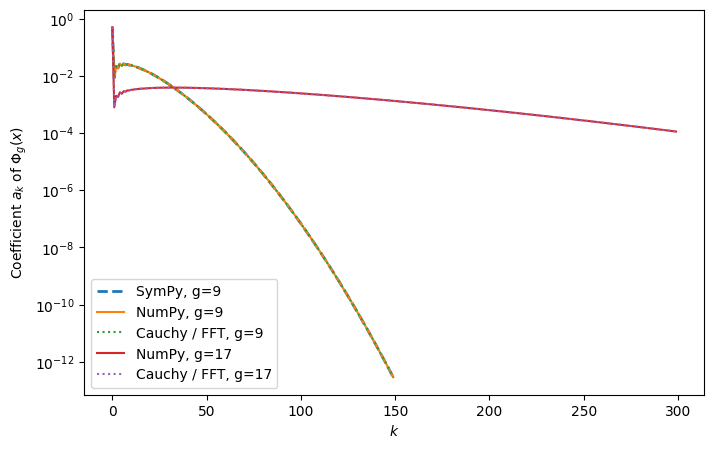

In [ ]:
g = 9
degree = 2 ** g

# --- SymPy coefficients ---
phi_sympy = Phi(g, mu_sympy)
sympy_coeffs = sp.Poly(phi_sympy, x).all_coeffs()
sympy_coeffs = np.array([float(c) for c in reversed(sympy_coeffs)])

# --- NumPy coefficient iteration ---
numpy_coeffs = Phi_numpy(g, mu_numpy_coeffs)

# --- Cauchy / FFT coefficients ---
num_points = 2 * degree
cauchy_coeffs = Phi_coefficients_real(
    g, num_points, mu_Cauchy_values, FFT=True
)[:degree + 1]

k = np.arange(degree + 1)

plt.figure(figsize=(8, 5))
plt.plot(k[:150], sympy_coeffs[:150], "--", label="SymPy, g={}".format(g), linewidth=2)
plt.plot(k[:150], numpy_coeffs[:150], "-", label="NumPy, g={}".format(g))
plt.plot(k[:150], cauchy_coeffs[:150], ":", label="Cauchy / FFT, g={}".format(g))


g = 17
degree = 2 ** g

# --- NumPy coefficient iteration ---
numpy_coeffs = Phi_numpy(g, mu_numpy_coeffs)

# --- Cauchy / FFT coefficients ---
num_points = 2 * degree
cauchy_coeffs = Phi_coefficients_real(
    g, num_points, mu_Cauchy_values, FFT=True
)[:degree + 1]

k = np.arange(degree + 1)

plt.plot(k[:1000], numpy_coeffs[:1000], "-", label="NumPy, g={}".format(g))
plt.plot(k[:1000], cauchy_coeffs[:1000], ":", label="Cauchy / FFT, g={}".format(g))

plt.xlabel("$k$")
plt.ylabel("Coefficient $a_k$ of $\\Phi_g(x)$")
plt.yscale('log')
plt.legend()
plt.show()


However, there are round-off errors to consider in the Cauchy integral approximation.  In this case, the errors occur for cases whose combined probability is significantly less than $10^{-15}$.

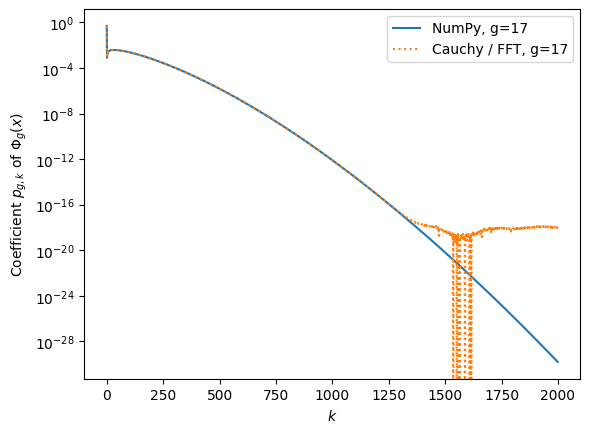

In [72]:
# --- Cauchy / FFT coefficients ---
num_points = 2 * degree
cauchy_coeffs = Phi_coefficients_real(
    g, num_points, mu_Cauchy_values, FFT=True
)[:degree + 1]

k = np.arange(degree + 1)

plt.plot(k[:2000], numpy_coeffs[:2000], "-", label="NumPy, g={}".format(g))
plt.plot(k[:2000], cauchy_coeffs[:2000], ":", label="Cauchy / FFT, g={}".format(g))

plt.xlabel("$k$")
plt.ylabel("Coefficient $p_{g,k}$ of $\\Phi_g(x)$")
plt.yscale('log')
plt.legend()
plt.show()


## Additional comments

```{prf:remark}
:label: remark-Cauchy_finite
For the Cauchy integral, if $\Phi(x)$ has a maximum degree and we perform our discretization giving a finite Riemann sumwith more terms than the maximum degree of $\Phi_g(x)$ the result is exact up to numerical precision.  That is, if the arithmetic is exact and $\Phi_g(x)$ is a polynomial, then as long as we have enough points in the discrete integral approximation, our coefficients will be exact.  If there is no maximum degree or there is arithmetic roundoff error, then using more points helps to reduce accumulated error (but there is a limit to how small the roundoff error can be), and using a smaller radius in the circle can also help.
```


```{prf:remark}
:label: remark-nonpolynomialCauchy
Note that if $\mu(x) = e^{2(x-1)}$ or something similar rather than a polynomial with only a few terms, then the Cauchy integral method would still work, but the other two methods would require some level of truncation before even beginning.  Keeping many terms would also slow those methods down significantly.
```

```{prf:remark}
:label: remark-CauchyOrthogonality

The method of multiplying by $e^{-ik\theta}$ and integrating in order to find the $k$-th coefficient is a generalization of a concept we encounter in Linear Algebra.  

If I have a vector $\vec{v} \in \mathbb{R}^3$, and I refuse to tell you what it is, but I agree to tell you its dot product with any vectors you ask, the easiest thing to try would be to get the dot products with $(1,0,0)$, $(0,1,0)$ and $(0,0,1)$.  By taking their dot product with $\vec{v}$ you immediately get its component in each of their directions.  

If instead you were interested in writing my vector $\vec{v}$ as a linear combination of $\vec{w}_1$,  $\vec{w}_2$ and $\vec{w}_3$.  My vector $\vec{v} = c_1\vec{w}_1 + c_2 \vec{w}_2 + c_3 \vec{w}_3$, even though we don't know what $c_1$, $c_2$, and $c_3$ are.  If you knew a vector $\vec{u}_1$ that was orthogonal to $\vec{w}_2$ and $\vec{w}_3$, but not to $\vec{w}_1$, then by calculating $\vec{v} \cdot \vec{u}_1$ you will get $c_1 \vec{w}_1 \cdot \vec{u_1}$, so 

$$
c_1 = \frac{\vec{v} \cdot \vec{u}_1}{\vec{u}_1 \cdot \vec{w}_1}
$$
You can similarly extract $c_2$ and $c_3$ given vectors with appropriate orthogonality properties.

Now I'll just make the claim that integrating a product is very similar to taking a dot product, and now the functions $e^{-ik\theta}$ are acting in a similar way to pick out the coefficient of $e^{ik\theta}$.  
```

## Self-test

**These are just notes to myself about what to create**

1. What happens in integral if we use fewer points than the $k$ we want?
2. Give integral with $z = re^{i\theta}$ for smaller $r$ and infinite series for $\mu(x)$.  Experimentally observe error.
3. Design problem showing Riemann sum is exact....